In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
df = pd.read_excel('W33836_business_analytics.xlsx', sheet_name='marketing') 

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,1985,Graduation,Married,70951.0,0,0,2013-04-05 00:00:00,66,239,...,1,0,0,0,0,0,0,3,11,0
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,5,0,0,0,0,1,0,3,11,1
2,9,1975,Master,Single,46098.0,1,1,18-08-2012,86,57,...,8,0,0,0,0,0,0,3,11,0
3,13,1947,PhD,Widow,25358.0,0,1,22-07-2013,57,19,...,6,0,0,0,0,0,0,3,11,0
4,17,1971,PhD,Married,60491.0,0,1,2013-06-09 00:00:00,81,637,...,5,0,0,0,0,0,0,3,11,0


In [4]:
#Label Encoding Education and Marital_Status
df['Education'] = df['Education'].astype('category').cat.codes
df['Marital_Status'] = df['Marital_Status'].astype('category').cat.codes

In [5]:
# Convert Dt_customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

C:\Users\Mridul Jain\AppData\Local\Temp\ipykernel_17808\2137518439.py:2: UserWarning: Parsing '15-06-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
C:\Users\Mridul Jain\AppData\Local\Temp\ipykernel_17808\2137518439.py:2: UserWarning: Parsing '18-08-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
C:\Users\Mridul Jain\AppData\Local\Temp\ipykernel_17808\2137518439.py:2: UserWarning: Parsing '22-07-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
C:\Users\Mridul Jain\AppData\Local\Temp\ipykernel_17808\2137518439.py:2: UserWarning: Parsing '15-02-2014' in DD/MM/YYYY format. Provide format or specify infer_da

In [6]:
# Set reference date
reference_date = pd.to_datetime('2022-01-31')

In [7]:
# Calculate number of days since joining
df['Days_since_joining'] = (reference_date - df['Dt_Customer']).dt.days

In [8]:
# Optionally, drop original Dt_customer 
df.drop('Dt_Customer', axis=1, inplace=True)

In [9]:
#Calculating Age while removing Birth Year
df['Age'] = 2022 - df['Year_Birth']
df = df.drop('Year_Birth', axis=1) 

In [10]:
df.isna().sum()

ID                      0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Days_since_joining      0
Age                     0
dtype: int64

In [11]:
#Replacing the null values in Income column with mean
df['Income'] = df['Income'].fillna(df['Income'].mean())

In [12]:
df.isna().sum()

ID                     0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Days_since_joining     0
Age                    0
dtype: int64

In [13]:
# Select numeric columns to check for outliers
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [14]:
# df now has outliers removed in all numeric columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [15]:
df

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_since_joining,Age
2,9,3,4,46098.0,1,1,86,57,0,27,...,0,0,0,0,0,3,11,0,3453,47
3,13,4,6,25358.0,0,1,57,19,0,5,...,0,0,0,0,0,3,11,0,3115,75
5,20,0,3,46891.0,0,1,91,43,12,23,...,0,0,0,0,0,3,11,0,3309,57
6,22,2,2,46310.0,1,0,99,185,2,88,...,0,0,0,0,0,3,11,0,3612,46
7,24,3,5,17144.0,1,1,96,18,2,19,...,0,0,0,0,0,3,11,0,2907,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,11166,2,3,49678.0,0,1,81,229,5,56,...,0,0,0,0,0,3,11,0,3285,61
2235,11178,3,4,42394.0,1,0,69,15,2,10,...,0,0,0,0,0,3,11,0,2871,50
2237,11187,1,4,26487.0,1,0,23,2,8,10,...,0,0,0,0,0,3,11,0,3178,44
2238,11188,2,5,26091.0,1,1,84,15,10,19,...,0,0,0,0,0,3,11,0,2897,65


In [16]:
#Saving Clean Data
df.to_excel('cleaned_data.xlsx', index=False)

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
#Loading Clean data
df = pd.read_excel('cleaned_data.xlsx')

In [19]:
df

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_since_joining,Age
0,9,3,4,46098.0,1,1,86,57,0,27,...,0,0,0,0,0,3,11,0,3453,47
1,13,4,6,25358.0,0,1,57,19,0,5,...,0,0,0,0,0,3,11,0,3115,75
2,20,0,3,46891.0,0,1,91,43,12,23,...,0,0,0,0,0,3,11,0,3309,57
3,22,2,2,46310.0,1,0,99,185,2,88,...,0,0,0,0,0,3,11,0,3612,46
4,24,3,5,17144.0,1,1,96,18,2,19,...,0,0,0,0,0,3,11,0,2907,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,11166,2,3,49678.0,0,1,81,229,5,56,...,0,0,0,0,0,3,11,0,3285,61
834,11178,3,4,42394.0,1,0,69,15,2,10,...,0,0,0,0,0,3,11,0,2871,50
835,11187,1,4,26487.0,1,0,23,2,8,10,...,0,0,0,0,0,3,11,0,3178,44
836,11188,2,5,26091.0,1,1,84,15,10,19,...,0,0,0,0,0,3,11,0,2897,65


In [20]:
#Dropping ID column 
df = df.drop('ID', axis=1)

In [21]:
#Keeping only numeric columns for clustering
X = df.select_dtypes(include=['int64', 'float64'])

In [22]:
#Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
#Finding optimal K using Silhouette Score
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=11, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)  # One score per k
    print(f"K={k}: Silhouette Score = {score:.4f}")

K=2: Silhouette Score = 0.2548
K=3: Silhouette Score = 0.1190
K=4: Silhouette Score = 0.1144
K=5: Silhouette Score = 0.1104
K=6: Silhouette Score = 0.0980
K=7: Silhouette Score = 0.0999
K=8: Silhouette Score = 0.0916
K=9: Silhouette Score = 0.0861
K=10: Silhouette Score = 0.0892


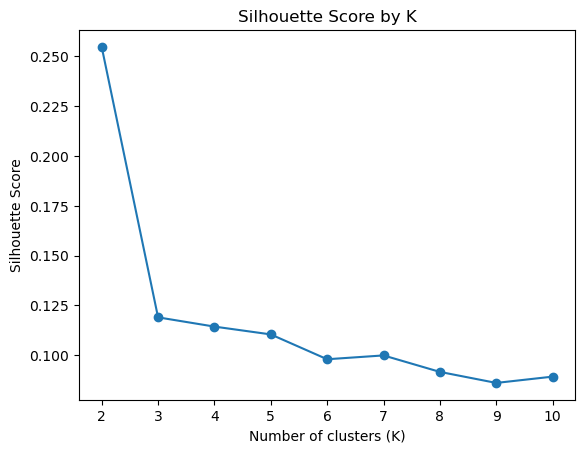

In [24]:
#Plotting silhouette scores to visualize best K
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K")
plt.show()

In [25]:
#Best K (highest silhouette score)
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best K is {best_k} with silhouette score {max(silhouette_scores):.4f}")

Best K is 2 with silhouette score 0.2548


In [26]:
#Final K-means with the optimal K
final_kmeans = KMeans(n_clusters=best_k, random_state=11, n_init=10)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)

In [27]:
# Cluster size and percentage
sizes = df['Cluster'].value_counts()
percentages = df['Cluster'].value_counts(normalize=True) * 100

# Mean values for numeric columns
avg_income = df.groupby('Cluster')['Income'].mean()
avg_age = df.groupby('Cluster')['Age'].mean()
avg_wine_spend = df.groupby('Cluster')['MntWines'].mean()



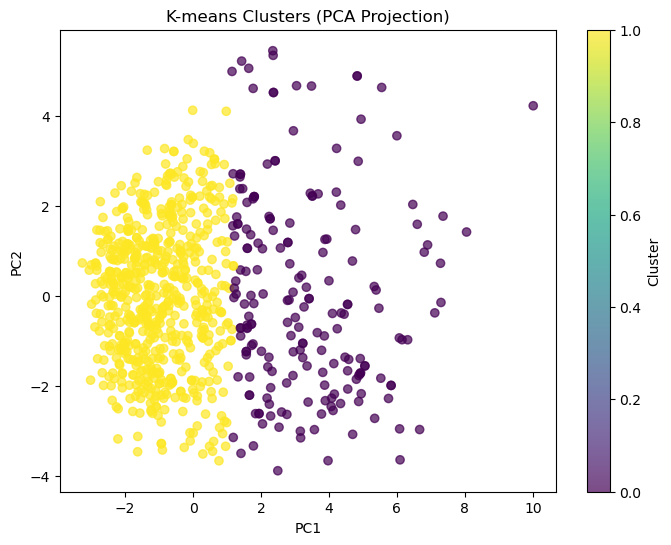

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clusters (PCA Projection)')
plt.colorbar(label='Cluster')
plt.show()

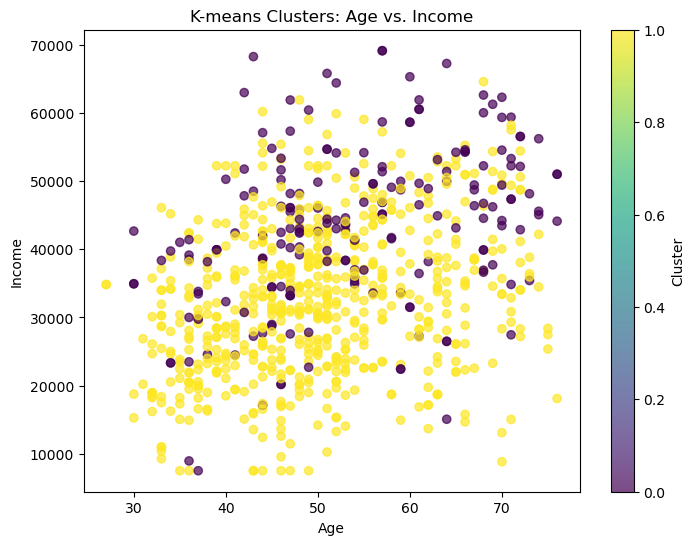

In [29]:
# Choose two features to visualize, e.g., 'Age' and 'Income'
plt.figure(figsize=(8,6))
plt.scatter(df['Age'], df['Income'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('K-means Clusters: Age vs. Income')
plt.colorbar(label='Cluster')
plt.show()

In [30]:
# Save or proceed with clustering
df.to_excel('cleaned_data_with_clusters.xlsx', index=False)

In [31]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            838 non-null    int64  
 1   Marital_Status       838 non-null    int64  
 2   Income               838 non-null    float64
 3   Kidhome              838 non-null    int64  
 4   Teenhome             838 non-null    int64  
 5   Recency              838 non-null    int64  
 6   MntWines             838 non-null    int64  
 7   MntFruits            838 non-null    int64  
 8   MntMeatProducts      838 non-null    int64  
 9   MntFishProducts      838 non-null    int64  
 10  MntSweetProducts     838 non-null    int64  
 11  MntGoldProds         838 non-null    int64  
 12  NumDealsPurchases    838 non-null    int64  
 13  NumWebPurchases      838 non-null    int64  
 14  NumCatalogPurchases  838 non-null    int64  
 15  NumStorePurchases    838 non-null    int

None

In [32]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Education,838.0,2.272076,1.147418,0.0,2.00,2.0,3.00,4.0
Marital_Status,838.0,3.693317,1.041655,1.0,3.00,3.0,5.00,6.0
Income,838.0,35033.483013,12120.017054,7500.0,26168.50,34566.0,43477.00,69139.0
Kidhome,838.0,0.784010,0.507890,0.0,0.00,1.0,1.00,2.0
Teenhome,838.0,0.494033,0.528145,0.0,0.00,0.0,1.00,2.0
Recency,838.0,51.101432,28.752817,0.0,26.00,51.0,77.00,99.0
MntWines,838.0,41.159905,54.299917,0.0,8.00,20.5,50.75,365.0
MntFruits,838.0,4.286396,6.220103,0.0,0.00,2.0,6.00,51.0
MntMeatProducts,838.0,21.069212,22.672938,0.0,7.00,14.0,25.00,206.0
MntFishProducts,838.0,6.065632,7.470483,0.0,0.00,3.0,8.00,47.0


In [33]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    display(f"- {col}: {df[col].nunique()} unique values")


 Visualizing the distribution of some numeric variables:


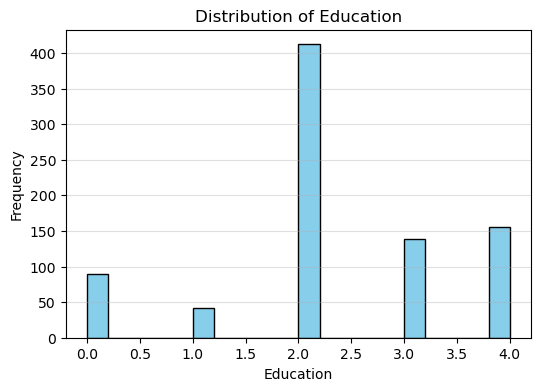

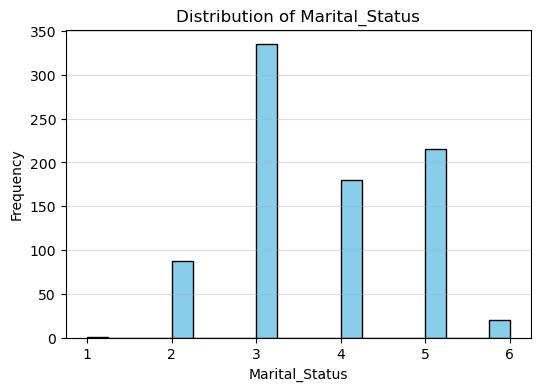

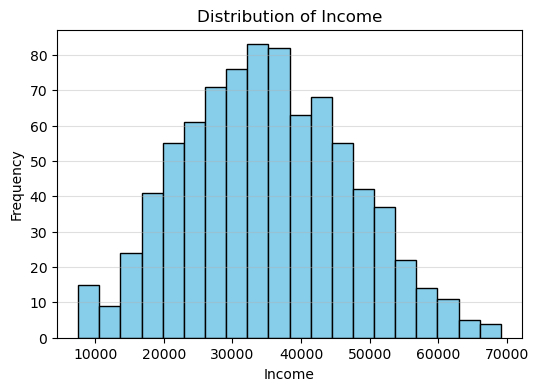

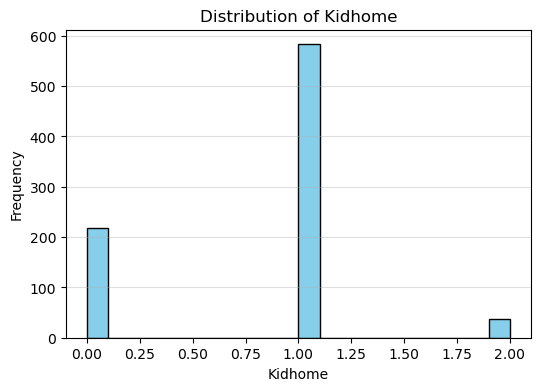

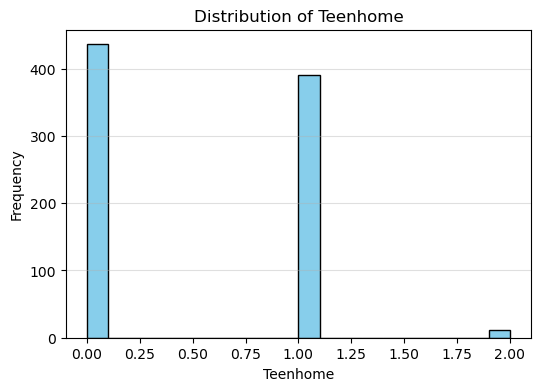

In [34]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("\n Visualizing the distribution of some numeric variables:")
for col in numeric_cols[:5]:  # plot first 5 numeric columns for simplicity
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.4)
    plt.show()

"\n Let's see how common each category is for some key columns:"


Value counts for 'Education':
2    412
4    156
3    138
0     90
1     42
Name: Education, dtype: int64


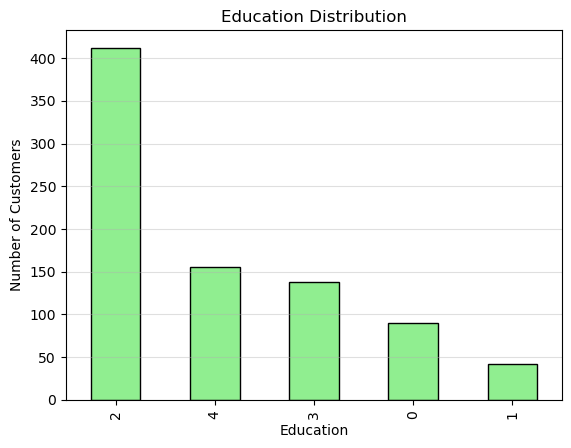


Value counts for 'Marital_Status':
3    335
5    215
4    180
2     87
6     20
1      1
Name: Marital_Status, dtype: int64


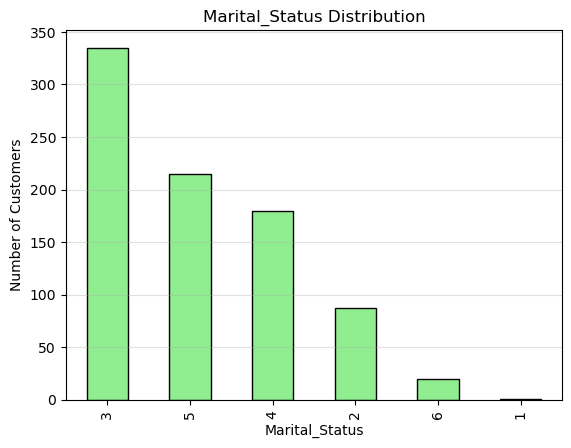

In [35]:
display("\n Let's see how common each category is for some key columns:")
for col in ['Education', 'Marital_Status']:
    if col in df.columns:
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts())
        df[col].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Number of Customers")
        plt.grid(axis='y', alpha=0.4)
        plt.show()

In [36]:
df.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 
         'Z_Revenue','Response'], axis=1, inplace=True)

'\n Checking correlations between columns:'

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_since_joining,Age,Cluster
Education,1.00,0.00,0.27,0.02,0.17,-0.04,0.26,-0.28,0.07,-0.29,-0.33,-0.17,0.03,0.12,0.06,0.09,-0.05,-0.12,0.24,-0.07
Marital_Status,0.00,1.00,0.00,-0.00,0.07,0.06,-0.02,-0.03,-0.01,-0.01,-0.06,0.01,0.01,-0.06,0.04,-0.05,-0.02,0.02,0.04,0.01
Income,0.27,0.00,1.00,-0.09,0.51,-0.00,0.55,-0.06,0.32,-0.07,-0.07,0.10,0.03,0.29,0.27,0.36,-0.33,-0.17,0.34,-0.38
Kidhome,0.02,-0.00,-0.09,1.00,-0.10,0.07,-0.27,-0.12,-0.09,-0.08,-0.10,-0.14,0.20,-0.12,-0.20,-0.23,0.19,-0.04,-0.18,0.20
Teenhome,0.17,0.07,0.51,-0.10,1.00,-0.02,0.32,-0.18,0.02,-0.23,-0.22,-0.01,0.24,0.08,0.14,0.20,-0.23,-0.06,0.58,-0.15
Recency,-0.04,0.06,-0.00,0.07,-0.02,1.00,-0.00,0.07,0.11,0.03,0.10,0.09,0.09,0.06,0.11,0.00,0.02,0.02,-0.00,-0.07
MntWines,0.26,-0.02,0.55,-0.27,0.32,-0.00,1.00,0.05,0.55,0.01,0.03,0.36,0.43,0.78,0.57,0.66,0.01,0.07,0.28,-0.69
MntFruits,-0.28,-0.03,-0.06,-0.12,-0.18,0.07,0.05,1.00,0.35,0.47,0.55,0.42,0.17,0.29,0.26,0.30,0.04,0.16,-0.09,-0.41
MntMeatProducts,0.07,-0.01,0.32,-0.09,0.02,0.11,0.55,0.35,1.00,0.41,0.34,0.43,0.45,0.73,0.49,0.60,0.12,0.15,0.05,-0.69
MntFishProducts,-0.29,-0.01,-0.07,-0.08,-0.23,0.03,0.01,0.47,0.41,1.00,0.45,0.37,0.17,0.27,0.25,0.27,0.01,0.17,-0.14,-0.35


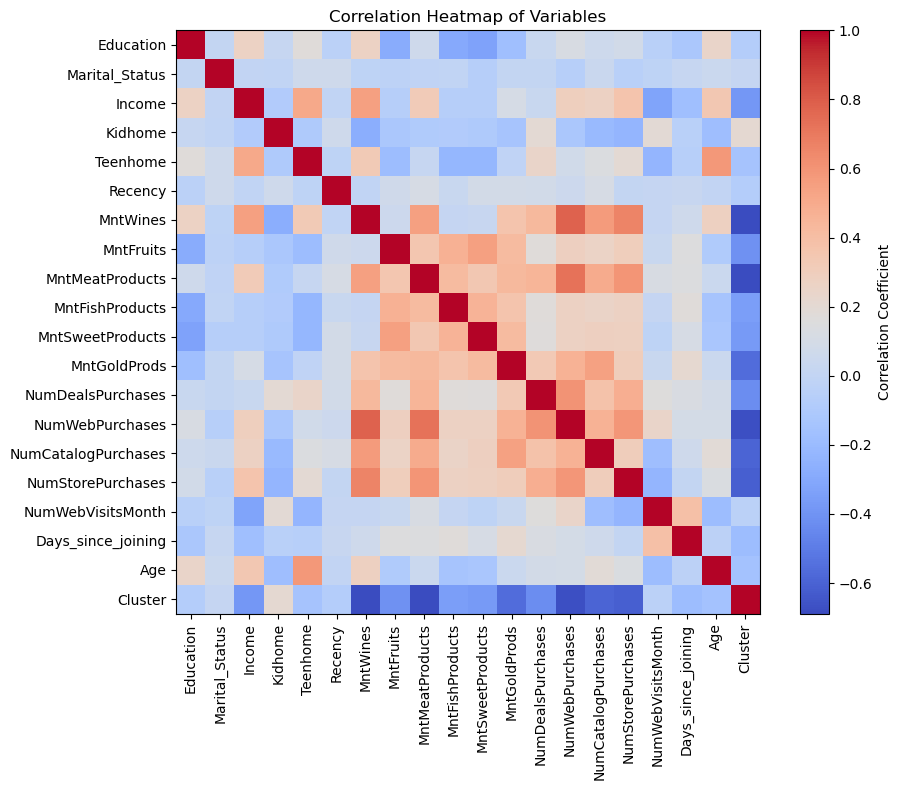

'\n Descriptive Analysis complete!'

'We have now explored:'

'- Dataset structure and summary statistics'

'- Missing values'

'- Distributions of key categorical variables'

'- Correlations among features'

In [37]:
# --- Correlation matrix ---
display("\n Checking correlations between columns:")
corr = df.corr()
display(corr.round(2))

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap of Variables")
plt.tight_layout()
plt.show()

display("\n Descriptive Analysis complete!")
display("We have now explored:")
display("- Dataset structure and summary statistics")
display("- Missing values")
display("- Distributions of key categorical variables")
display("- Correlations among features")


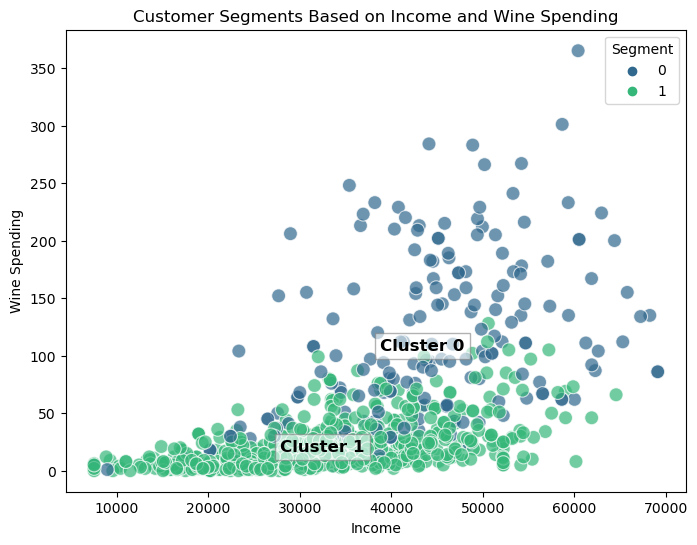

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))   # <--- SAFE SIZE

# Your scatterplot code
sns.scatterplot(
    data=df,
    x="Income",
    y="MntWines",
    hue="Cluster",
    palette="viridis",
    s=100,
    alpha=0.7
)

# Centroid code (your original block)
centroids = df.groupby("Cluster")[["Income", "MntWines"]].mean()
for i, row in centroids.iterrows():
    plt.text(
        row["Income"],
        row["MntWines"],
        f"Cluster {i}",
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )
# Add labels and title
plt.xlabel("Income")
plt.ylabel("Wine Spending")
plt.title("Customer Segments Based on Income and Wine Spending")

# Show the legend and plot
plt.legend(title="Segment")
plt.show()


In [39]:
#Demographics Features
df['Household_Size'] = df['Kidhome'] + df['Teenhome']
demographics = ['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Household_Size']

#Spending Behaviour
df['Total_Spending'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] +
                        df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
spending = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds', 'Total_Spending']

#Shopping Preferences
df['Total_Purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
shopping = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Total_Purchases']

#Engagement
engagement = ['Recency', 'NumWebVisitsMonth', 'Complain']

In [40]:
def assign_segment(row):
    if row['Age'] > 55 and row['Income'] > df['Income'].quantile(0.75) and row['Total_Spending'] > df['Total_Spending'].quantile(0.75):
        return "Premium"
    elif row['Total_Spending'] > df['Total_Spending'].quantile(0.5) and row['Store_Purchase_Ratio'] > 0.5:
        return "Value Store Shopper"
    elif row['Web_Purchase_Ratio'] > 0.3 and row['NumWebVisitsMonth'] > df['NumWebVisitsMonth'].median():
        return "Digital Enthusiast"
    else:
        return "Budget Conscious"


In [41]:
# Calculate total purchases (add this column first)
df['Total_Purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Now calculate each channel's purchase ratio
df['Store_Purchase_Ratio'] = df['NumStorePurchases'] / (df['Total_Purchases'] + 1e-6)  # add epsilon to avoid division by zero
df['Web_Purchase_Ratio'] = df['NumWebPurchases'] / (df['Total_Purchases'] + 1e-6)
df['Catalog_Purchase_Ratio'] = df['NumCatalogPurchases'] / (df['Total_Purchases'] + 1e-6)

In [42]:
df['Segment'] = df.apply(assign_segment, axis=1)


In [43]:
print(df['Segment'].value_counts())


Budget Conscious       471
Value Store Shopper    157
Digital Enthusiast     142
Premium                 68
Name: Segment, dtype: int64


In [44]:
print(pd.crosstab(df['Cluster'], df['Segment']))

Segment  Budget Conscious  Digital Enthusiast  Premium  Value Store Shopper
Cluster                                                                    
0                      48                  50       62                   36
1                     423                  92        6                  121


In [45]:
print(df[['Cluster', 'Segment', 'Age', 'Income', 'Total_Spending', 'NumWebPurchases', 'NumStorePurchases']].head(20))


    Cluster              Segment  Age   Income  Total_Spending  \
0         0   Digital Enthusiast   47  46098.0             120   
1         1     Budget Conscious   75  25358.0              32   
2         0              Premium   57  46891.0             183   
3         0   Digital Enthusiast   46  46310.0             309   
4         1     Budget Conscious   62  17144.0              47   
5         1     Budget Conscious   52  20587.0              25   
6         1  Value Store Shopper   50  46423.0              92   
7         1     Budget Conscious   69  51411.0              18   
8         1     Budget Conscious   53  25293.0              37   
9         1     Budget Conscious   41  27733.0              57   
10        1  Value Store Shopper   47  22212.0              69   
11        1  Value Store Shopper   34  34176.0              89   
12        1     Budget Conscious   71  30833.0              28   
13        1     Budget Conscious   69  23272.0              46   
14        

In [46]:
# Promotion recommendations based on segment characteristics
def recommend_promotion(row):
    total_spending_mean = df['Total_Spending'].mean()
    income_mean = df['Income'].mean()
    household_mean = df['Household_Size'].mean()
    web_visits_mean = df['NumWebVisitsMonth'].mean()
    recency_mean = df['Recency'].mean()
    
    if row['Total_Spending'] > total_spending_mean and row['Income'] > income_mean:
        return "Exclusive VIP loyalty & premium bundles"
    elif row['Household_Size'] >= household_mean:
        return "Family value packs and bundle discounts"
    elif row['NumWebVisitsMonth'] > web_visits_mean:
        return "Online coupons and free delivery"
    elif row['Recency'] > recency_mean:
        return "Reactivation discount / Win-back campaign"
    else:
        return "General 10% off promotion"

df['Promotion_Strategy'] = df.apply(recommend_promotion, axis=1)

print("\nPromotion Strategy Distribution:")
print(df['Promotion_Strategy'].value_counts())



Promotion Strategy Distribution:
Online coupons and free delivery             252
Family value packs and bundle discounts      211
Exclusive VIP loyalty & premium bundles      201
General 10% off promotion                     98
Reactivation discount / Win-back campaign     76
Name: Promotion_Strategy, dtype: int64


In [47]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,Cluster,Household_Size,Total_Spending,Total_Purchases,Store_Purchase_Ratio,Web_Purchase_Ratio,Catalog_Purchase_Ratio,Segment,Promotion_Strategy
0,3,4,46098.0,1,1,86,57,0,27,0,...,47,0,2,120,7,0.285714,0.428571,0.285714,Digital Enthusiast,Exclusive VIP loyalty & premium bundles
1,4,6,25358.0,0,1,57,19,0,5,0,...,75,1,1,32,4,0.750000,0.250000,0.000000,Budget Conscious,Reactivation discount / Win-back campaign
2,0,3,46891.0,0,1,91,43,12,23,29,...,57,0,1,183,7,0.571428,0.285714,0.142857,Premium,Exclusive VIP loyalty & premium bundles
3,2,2,46310.0,1,0,99,185,2,88,15,...,46,0,1,309,12,0.416667,0.500000,0.083333,Digital Enthusiast,Exclusive VIP loyalty & premium bundles
4,3,5,17144.0,1,1,96,18,2,19,0,...,62,1,2,47,7,0.571428,0.428571,0.000000,Budget Conscious,Family value packs and bundle discounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2,3,49678.0,0,1,81,229,5,56,3,...,61,0,1,315,12,0.333333,0.500000,0.166667,Premium,Exclusive VIP loyalty & premium bundles
834,3,4,42394.0,1,0,69,15,2,10,0,...,50,1,1,32,4,0.750000,0.250000,0.000000,Budget Conscious,Online coupons and free delivery
835,1,4,26487.0,1,0,23,2,8,10,12,...,44,1,1,69,6,0.500000,0.333333,0.166667,Budget Conscious,General 10% off promotion
836,2,5,26091.0,1,1,84,15,10,19,8,...,65,1,2,89,6,0.500000,0.333333,0.166667,Budget Conscious,Family value packs and bundle discounts


In [48]:
#PROMOTION STRATEGY DISTRIBUTION
print("DISTRIBUTION OF PROMOTION STRATEGIES")
strategy_counts = df['Promotion_Strategy'].value_counts()
strategy_pct = (df['Promotion_Strategy'].value_counts(normalize=True) * 100).round(2)

strategy_summary = pd.DataFrame({
    'Promotion Strategy': strategy_counts.index,
    'Customer Count': strategy_counts.values,
    'Percentage': [f"{pct}%" for pct in strategy_pct.values]  # FIX: Convert each percentage to string with %
})

print(strategy_summary.to_string(index=False))

DISTRIBUTION OF PROMOTION STRATEGIES
                       Promotion Strategy  Customer Count Percentage
         Online coupons and free delivery             252     30.07%
  Family value packs and bundle discounts             211     25.18%
  Exclusive VIP loyalty & premium bundles             201     23.99%
                General 10% off promotion              98     11.69%
Reactivation discount / Win-back campaign              76      9.07%


In [49]:
from sklearn.linear_model import LogisticRegression


In [50]:
# DEFINE 5 PROMOTIONAL CAMPAIGNS
campaigns = {
    'Campaign_1_Premium': {
        'name': 'Exclusive VIP loyalty & premium bundles',
        'base_response_rate': 0.35,
        'target_condition': (df['Total_Spending'] > df['Total_Spending'].quantile(0.75)) & 
                           (df['Income'] > df['Income'].quantile(0.75))
    },
    'Campaign_2_Family': {
        'name': 'Family value packs and bundle discounts',
        'base_response_rate': 0.25,
        'target_condition': (df['Household_Size'] >= 2) & (df['Age'] < 60)
    },
    'Campaign_3_Digital': {
        'name': 'Online coupons and free delivery',
        'base_response_rate': 0.30,
        'target_condition': (df['Web_Purchase_Ratio'] > 0.3) | 
                           (df['NumWebVisitsMonth'] > df['NumWebVisitsMonth'].quantile(0.5))
    },
    'Campaign_4_Reactivation': {
        'name': 'Reactivation discount / Win-back campaign',
        'base_response_rate': 0.20,
        'target_condition': (df['Recency'] > df['Recency'].quantile(0.75))
    },
    'Campaign_5_General': {
        'name': 'General 10% off promotion',
        'base_response_rate': 0.18,
        'target_condition': df['Income'] < df['Income'].quantile(0.50)
    }
}

In [51]:
# SIMULATE CAMPAIGN RESPONSES
print("\n" + "="*80)
print("SIMULATING RESPONSES FOR 5 CAMPAIGNS")
print("="*80)

for campaign_key, campaign_info in campaigns.items():
    target_customers = campaign_info['target_condition']
    base_rate = campaign_info['base_response_rate']
    
    # Initialize campaign response column
    df[campaign_key] = 0
    
    # Get targeted customer indices
    targeted_indices = df[target_customers].index
    
    # Simulate responses with probability adjustments
    for idx in targeted_indices:
        acceptance_prob = base_rate
        
        # Increase probability for high-value customers
        if df.loc[idx, 'Income'] > df['Income'].quantile(0.75):
            acceptance_prob += 0.05
        
        if df.loc[idx, 'Total_Spending'] > df['Total_Spending'].quantile(0.75):
            acceptance_prob += 0.05
        
        # Recent customers more likely to accept
        if df.loc[idx, 'Recency'] < 30:
            acceptance_prob += 0.08
        
        # Engaged customers more likely to accept
        if df.loc[idx, 'NumWebVisitsMonth'] > df['NumWebVisitsMonth'].quantile(0.75):
            acceptance_prob += 0.05
        
        # Cap at 90%
        acceptance_prob = min(acceptance_prob, 0.90)
        
        # Simulate acceptance (1 or 0)
        df.loc[idx, campaign_key] = np.random.binomial(1, acceptance_prob)
    
    # Print campaign stats
    total_targeted = target_customers.sum()
    total_accepted = df[campaign_key].sum()
    response_rate = (total_accepted / total_targeted * 100) if total_targeted > 0 else 0
    
    print(f"\n{campaign_info['name']}")
    print(f"  Targeted: {total_targeted} customers")
    print(f"  Accepted: {int(total_accepted)} customers")
    print(f"  Response Rate: {response_rate:.2f}%")


SIMULATING RESPONSES FOR 5 CAMPAIGNS

Exclusive VIP loyalty & premium bundles
  Targeted: 112 customers
  Accepted: 49 customers
  Response Rate: 43.75%

Family value packs and bundle discounts
  Targeted: 181 customers
  Accepted: 57 customers
  Response Rate: 31.49%

Online coupons and free delivery
  Targeted: 590 customers
  Accepted: 212 customers
  Response Rate: 35.93%

Reactivation discount / Win-back campaign
  Targeted: 203 customers
  Accepted: 56 customers
  Response Rate: 27.59%

General 10% off promotion
  Targeted: 419 customers
  Accepted: 82 customers
  Response Rate: 19.57%


In [52]:
# CREATE OVERALL RESPONSE METRICS
print("\n" + "="*80)
print("CREATING OVERALL RESPONSE METRICS")
print("="*80)

campaign_columns = ['Campaign_1_Premium', 'Campaign_2_Family', 'Campaign_3_Digital', 
                    'Campaign_4_Reactivation', 'Campaign_5_General']

df['Total_Campaign_Responses'] = df[campaign_columns].sum(axis=1)
df['Overall_Response'] = (df['Total_Campaign_Responses'] > 0).astype(int)

print(f"\nCustomers who responded to ANY campaign: {df['Overall_Response'].sum()} ({df['Overall_Response'].mean()*100:.2f}%)")
print(f"Customers with NO response: {(1-df['Overall_Response']).sum()} ({(1-df['Overall_Response'].mean())*100:.2f}%)")


CREATING OVERALL RESPONSE METRICS

Customers who responded to ANY campaign: 377 (44.99%)
Customers with NO response: 461 (55.01%)


In [53]:
# PREDICT RESPONSE USING MACHINE LEARNING

print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*80)

# Select features for prediction
feature_columns = ['Age', 'Income', 'Total_Spending', 'NumDealsPurchases', 
                   'NumWebVisitsMonth', 'Recency', 'NumWebPurchases', 
                   'NumStorePurchases', 'Household_Size']

X = df[feature_columns].fillna(df[feature_columns].mean())
y = df['Overall_Response']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                     random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions on full dataset
X_all_scaled = scaler.transform(X)
df['Predicted_Response_Probability'] = model.predict_proba(X_all_scaled)[:, 1]
df['Predicted_Response'] = model.predict(X_all_scaled)

# Print model performance
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

print(f"\nModel Performance:")
print(f"  Training Accuracy: {train_accuracy*100:.2f}%")
print(f"  Testing Accuracy: {test_accuracy*100:.2f}%")
print(f"  Predicted Responders: {df['Predicted_Response'].sum()} customers ({df['Predicted_Response'].mean()*100:.2f}%)")


TRAINING LOGISTIC REGRESSION MODEL

Model Performance:
  Training Accuracy: 63.48%
  Testing Accuracy: 60.71%
  Predicted Responders: 280 customers (33.41%)


In [54]:
# CALCULATE FINAL ACCEPTANCE RATES

print("\n" + "="*80)
print("FINAL ACCEPTANCE RATES BY CAMPAIGN")
print("="*80)

campaign_stats = []
for campaign_key, campaign_info in campaigns.items():
    total_response = df[campaign_key].sum()
    total_targeted = campaign_info['target_condition'].sum()
    response_rate = (total_response / total_targeted * 100) if total_targeted > 0 else 0
    
    campaign_stats.append({
        'Campaign': campaign_info['name'],
        'Targeted': total_targeted,
        'Accepted': int(total_response),
        'Acceptance_Rate_%': round(response_rate, 2)
    })

campaign_stats_df = pd.DataFrame(campaign_stats).sort_values('Acceptance_Rate_%', ascending=False)

print("\n" + campaign_stats_df.to_string(index=False))


FINAL ACCEPTANCE RATES BY CAMPAIGN

                                 Campaign  Targeted  Accepted  Acceptance_Rate_%
  Exclusive VIP loyalty & premium bundles       112        49              43.75
         Online coupons and free delivery       590       212              35.93
  Family value packs and bundle discounts       181        57              31.49
Reactivation discount / Win-back campaign       203        56              27.59
                General 10% off promotion       419        82              19.57


In [55]:
# ACCEPTANCE RATES BY PROMOTION STRATEGY
print("\n" + "="*80)
print("ACCEPTANCE RATES BY PROMOTION STRATEGY")
print("="*80)

strategy_acceptance = []
for promotion_strategy in df['Promotion_Strategy'].unique():
    strategy_df = df[df['Promotion_Strategy'] == promotion_strategy]
    
    total_customers = len(strategy_df)
    responders = strategy_df['Overall_Response'].sum()
    response_rate = (responders / total_customers * 100) if total_customers > 0 else 0
    
    strategy_acceptance.append({
        'Promotion Strategy': promotion_strategy,
        'Total Customers': total_customers,
        'Responders': int(responders),
        'Response Rate_%': round(response_rate, 2)
    })

strategy_df_result = pd.DataFrame(strategy_acceptance).sort_values('Response Rate_%', ascending=False)

print("\n" + strategy_df_result.to_string(index=False))



ACCEPTANCE RATES BY PROMOTION STRATEGY

                       Promotion Strategy  Total Customers  Responders  Response Rate_%
  Exclusive VIP loyalty & premium bundles              201         112            55.72
         Online coupons and free delivery              252         122            48.41
  Family value packs and bundle discounts              211          94            44.55
Reactivation discount / Win-back campaign               76          27            35.53
                General 10% off promotion               98          22            22.45


In [56]:
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save complete dataset with campaign responses
df.to_excel('data_with_campaign_responses_final.xlsx', index=False)
print("\n✓ Saved: data_with_campaign_responses_final.xlsx")

# Save campaign statistics
campaign_stats_df.to_csv('campaign_acceptance_rates.csv', index=False)
print("✓ Saved: campaign_acceptance_rates.csv")

# Save strategy acceptance
strategy_df_result.to_csv('acceptance_by_promotion_strategy.csv', index=False)
print("✓ Saved: acceptance_by_promotion_strategy.csv")


SAVING RESULTS

✓ Saved: data_with_campaign_responses_final.xlsx
✓ Saved: campaign_acceptance_rates.csv
✓ Saved: acceptance_by_promotion_strategy.csv


In [57]:
# DISPLAY SUMMARY
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

best_campaign = campaign_stats_df.iloc[0]
worst_campaign = campaign_stats_df.iloc[-1]

print(f"BEST CAMPAIGN: {best_campaign['Campaign']}")
print(f"  Acceptance Rate: {best_campaign['Acceptance_Rate_%']}%")
print(f"  Customers: {best_campaign['Targeted']} targeted, {best_campaign['Accepted']} accepted")

print(f"WORST CAMPAIGN: {worst_campaign['Campaign']}")
print(f"  Acceptance Rate: {worst_campaign['Acceptance_Rate_%']}%")
print(f"  Customers: {worst_campaign['Targeted']} targeted, {worst_campaign['Accepted']} accepted")

print(f"OVERALL STATISTICS:")
print(f"  Total Customers: {len(df)}")
print(f"  Total Responders (ANY campaign): {df['Overall_Response'].sum()}")
print(f"  Overall Response Rate: {df['Overall_Response'].mean()*100:.2f}%")



SUMMARY
BEST CAMPAIGN: Exclusive VIP loyalty & premium bundles
  Acceptance Rate: 43.75%
  Customers: 112 targeted, 49 accepted
WORST CAMPAIGN: General 10% off promotion
  Acceptance Rate: 19.57%
  Customers: 419 targeted, 82 accepted
OVERALL STATISTICS:
  Total Customers: 838
  Total Responders (ANY campaign): 377
  Overall Response Rate: 44.99%


In [58]:
# Define your 6 product categories
products = {
    'Wines': 'MntWines',
    'Fruits': 'MntFruits',
    'Meat Products': 'MntMeatProducts',
    'Fish Products': 'MntFishProducts',
    'Sweet Products': 'MntSweetProducts',
    'Gold Products': 'MntGoldProds'
}

In [59]:
#TOTAL REVENUE BY PRODUCT
print("TOTAL REVENUE BY PRODUCT CATEGORY")
total_revenue = {}
for product_name, column_name in products.items():
    total = df[column_name].sum()
    total_revenue[product_name] = total
    print(f"{product_name}: ${total:,.2f}")
    

TOTAL REVENUE BY PRODUCT CATEGORY
Wines: $34,492.00
Fruits: $3,592.00
Meat Products: $17,656.00
Fish Products: $5,083.00
Sweet Products: $3,349.00
Gold Products: $10,353.00


In [60]:
#AVERAGE REVENUE PER CUSTOMER
print("AVERAGE REVENUE PER CUSTOMER")
avg_revenue_per_customer = {}
for product_name, column_name in products.items():
    avg = df[column_name].mean()
    avg_revenue_per_customer[product_name] = avg
    print(f"{product_name}: ${avg:,.2f} per customer")

AVERAGE REVENUE PER CUSTOMER
Wines: $41.16 per customer
Fruits: $4.29 per customer
Meat Products: $21.07 per customer
Fish Products: $6.07 per customer
Sweet Products: $4.00 per customer
Gold Products: $12.35 per customer


In [61]:
#DETAILED STATISTICS BY PRODUCT
print("DETAILED STATISTICS BY PRODUCT")
stats_data = []
for product_name, column_name in products.items():
    product_data = df[column_name]
    
    stats_data.append({
        'Product': product_name,
        'Total_Revenue': f"${product_data.sum():,.2f}",
        'Avg_Per_Customer': f"${product_data.mean():,.2f}",
        'Median': f"${product_data.median():,.2f}",
        'Min': f"${product_data.min():,.2f}",
        'Max': f"${product_data.max():,.2f}",
        'Std_Dev': f"${product_data.std():,.2f}",
        'Customers_Who_Bought': (product_data > 0).sum(),
        'Avg_When_Purchased': f"${product_data[product_data > 0].mean():,.2f}"
    })

stats_df = pd.DataFrame(stats_data)
print("\n" + stats_df.to_string(index=False))

DETAILED STATISTICS BY PRODUCT

       Product Total_Revenue Avg_Per_Customer Median   Min     Max Std_Dev  Customers_Who_Bought Avg_When_Purchased
         Wines    $34,492.00           $41.16 $20.50 $0.00 $365.00  $54.30                   826             $41.76
        Fruits     $3,592.00            $4.29  $2.00 $0.00  $51.00   $6.22                   618              $5.81
 Meat Products    $17,656.00           $21.07 $14.00 $0.00 $206.00  $22.67                   837             $21.09
 Fish Products     $5,083.00            $6.07  $3.00 $0.00  $47.00   $7.47                   621              $8.19
Sweet Products     $3,349.00            $4.00  $2.00 $0.00  $25.00   $4.95                   606              $5.53
 Gold Products    $10,353.00           $12.35  $8.00 $0.00  $66.00  $12.38                   802             $12.91


In [62]:
#WHICH PRODUCT LEFT EARLIEST (DECLINE ANALYSIS)

print("WHICH PRODUCT LEFT EARLIEST (DEMAND DECLINE)")

# Count how many customers still buying each product
# (We assume lower count = product left earlier)

product_adoption = {}

for product_name, column_name in products.items():
    total_customers = len(df)
    buyers = (df[column_name] > 0).sum()
    non_buyers = total_customers - buyers
    adoption_rate = (buyers / total_customers) * 100
    
    # Recency for this product (average of customer's last purchase)
    # Lower recency = still buying, High recency = stopped buying
    product_data = df[df[column_name] > 0]
    
    if len(product_data) > 0:
        avg_recency = product_data['Recency'].mean()
        avg_spending = product_data[column_name].mean()
    else:
        avg_recency = 0
        avg_spending = 0
    
    product_adoption[product_name] = {
        'buyers': buyers,
        'non_buyers': non_buyers,
        'adoption_rate': adoption_rate,
        'avg_recency': avg_recency,
        'avg_spending': avg_spending
    }

print("\nProduct Adoption & Recency Analysis:")
print("-"*80)

adoption_df = pd.DataFrame([
    {
        'Product': product_name,
        'Customers_Buying': data['buyers'],
        'Customers_NOT_Buying': data['non_buyers'],
        'Adoption_Rate_%': round(data['adoption_rate'], 2),
        'Avg_Recency_Days': round(data['avg_recency'], 1),
        'Avg_Spending': f"${data['avg_spending']:.2f}"
    }
    for product_name, data in product_adoption.items()
]).sort_values('Avg_Recency_Days', ascending=False)

print("\n" + adoption_df.to_string(index=False))

print("\nInterpretation:")
print("-"*80)
print("• HIGHEST Recency = Product LEFT EARLIEST (customers stopped buying)")
print("• LOWEST Recency = Product is MOST ACTIVE (customers still buying)")

# Find which left earliest
earliest_product = adoption_df.iloc[0]
latest_product = adoption_df.iloc[-1]

print(f"\n✗ PRODUCT THAT LEFT EARLIEST: {earliest_product['Product']}")
print(f"   Average Days Since Last Purchase: {earliest_product['Avg_Recency_Days']} days")
print(f"   Still Being Purchased By: {earliest_product['Customers_Buying']} customers ({(earliest_product['Customers_Buying']/len(df)*100):.1f}%)")

print(f"\n✓ PRODUCT STILL MOST ACTIVE: {latest_product['Product']}")
print(f"   Average Days Since Last Purchase: {latest_product['Avg_Recency_Days']} days")
print(f"   Still Being Purchased By: {latest_product['Customers_Buying']} customers ({(latest_product['Customers_Buying']/len(df)*100):.1f}%)")


WHICH PRODUCT LEFT EARLIEST (DEMAND DECLINE)

Product Adoption & Recency Analysis:
--------------------------------------------------------------------------------

       Product  Customers_Buying  Customers_NOT_Buying  Adoption_Rate_%  Avg_Recency_Days Avg_Spending
 Fish Products               621                   217            74.11              52.4        $8.19
        Fruits               618                   220            73.75              52.2        $5.81
Sweet Products               606                   232            72.32              51.5        $5.53
 Gold Products               802                    36            95.70              51.2       $12.91
 Meat Products               837                     1            99.88              51.1       $21.09
         Wines               826                    12            98.57              51.0       $41.76

Interpretation:
--------------------------------------------------------------------------------
• HIGHEST Recenc

In [68]:
import plotly.graph_objects as go
data = {
    "Product": ["Fish Products","Fruits","Sweet Products","Gold Products","Meat Products","Wines"], 
    "Avg_Recency_Days": [52.4, 52.2, 51.5, 51.2, 51.1, 51.0], 
    "Adoption_Rate_%": [74.11, 73.75, 72.32, 95.70, 99.88, 98.57]
}

df = pd.DataFrame(data)

# Sort by Avg_Recency_Days descending
df_sorted = df.sort_values('Avg_Recency_Days', ascending=False)

# Create grouped bar chart
fig = go.Figure()

# Add recency bars (blue)
fig.add_trace(go.Bar(
    name='Avg Recency Days',
    x=df_sorted['Product'],
    y=df_sorted['Avg_Recency_Days'],
    marker_color='#1FB8CD',  # Blue from brand colors
    text=df_sorted['Avg_Recency_Days'],
    textposition='outside',
    texttemplate='%{text:.1f}'
))

# Add adoption rate bars (green) 
fig.add_trace(go.Bar(
    name='Adoption Rate %',
    x=df_sorted['Product'],
    y=df_sorted['Adoption_Rate_%'],
    marker_color='#2E8B57',  # Green from brand colors
    text=df_sorted['Adoption_Rate_%'],
    textposition='outside',
    texttemplate='%{text:.1f}'
))

# Update layout
fig.update_layout(
    title='Product Recency vs Adoption',
    xaxis_title='Product',
    yaxis_title='Values',
    barmode='group',
    legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='center', x=0.5)
)

# Update traces to prevent clipping
fig.update_traces(cliponaxis=False)
fig.write_html("product_recency_vs_adoption.html")
fig.show()


In [65]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
df = pd.read_excel('data_with_campaign_responses_final.xlsx')
periods = 12  # How many periods to simulate, e.g. months
# Define product columns
products = {
    'Wines': 'MntWines',
    'Fruits': 'MntFruits',
    'Meat Products': 'MntMeatProducts',
    'Fish Products': 'MntFishProducts',
    'Sweet Products': 'MntSweetProducts',
    'Gold Products': 'MntGoldProds'
}
expsmooth_forecast = {}
print("EXPONENTIAL SMOOTHING FORECAST FOR NEXT 3 PERIODS")

for pname, col in products.items():
    # Aggregate historical demand for the product
    shuffled = df[col].sample(frac=1, random_state=0).reset_index(drop=True)
    if len(shuffled) < periods:
        series = shuffled
    else:
        n = len(shuffled)
    trim = (n // periods) * periods
    data = shuffled[:trim].values
    series = data.reshape((periods, -1)).sum(axis=1)

    # Exponential smoothing
    if len(series) < 3 or np.all(series == 0):
        forecast = [0,0,0]
    else:
        model = SimpleExpSmoothing(series)
        fit = model.fit(smoothing_level=0.6, optimized=False)
        forecast = fit.forecast(3)
    
    expsmooth_forecast[pname] = {
        'historical': np.round(series,2).tolist(),
        'forecast_next_3': np.round(forecast,2).tolist()
    }
    print(f"\n{pname}:")
    print(f" Past Periods: {series}")
    print(f" Next 3 Forecast: {np.round(forecast,2)}")


EXPONENTIAL SMOOTHING FORECAST FOR NEXT 3 PERIODS

Wines:
 Past Periods: [2462 2413 3303 3129 2923 4064 2189 2768 3145 3060 2369 2330]
 Next 3 Forecast: [2451.92 2451.92 2451.92]

Fruits:
 Past Periods: [258 182 312 386 271 325 391 376 272 285 262 218]
 Next 3 Forecast: [240.95 240.95 240.95]

Meat Products:
 Past Periods: [1507 1124 1554 1625 1199 1958 1231 1458 1602 1527 1505 1204]
 Next 3 Forecast: [1328.67 1328.67 1328.67]

Fish Products:
 Past Periods: [358 301 414 475 389 425 447 448 391 495 471 393]
 Next 3 Forecast: [422.71 422.71 422.71]

Sweet Products:
 Past Periods: [283 229 238 324 266 275 290 320 301 281 285 231]
 Next 3 Forecast: [253.36 253.36 253.36]

Gold Products:
 Past Periods: [688 713 943 950 849 942 977 872 782 909 783 842]
 Next 3 Forecast: [833.55 833.55 833.55]


In [66]:
# Data from the provided JSON
data = {
    "Wines": {"past": [2462, 2413, 3303, 3129, 2923, 4064, 2189, 2768, 3145, 3060, 2369, 2330], "forecast": [2451.92, 2451.92, 2451.92]},
    "Fruits": {"past": [258, 182, 312, 386, 271, 325, 391, 376, 272, 285, 262, 218], "forecast": [240.95, 240.95, 240.95]},
    "Meat Products": {"past": [1507, 1124, 1554, 1625, 1199, 1958, 1231, 1458, 1602, 1527, 1505, 1204], "forecast": [1328.67, 1328.67, 1328.67]},
    "Fish Products": {"past": [358, 301, 414, 475, 389, 425, 447, 448, 391, 495, 471, 393], "forecast": [422.71, 422.71, 422.71]},
    "Sweet Products": {"past": [283, 229, 238, 324, 266, 275, 290, 320, 301, 281, 285, 231], "forecast": [253.36, 253.36, 253.36]},
    "Gold Products": {"past": [688, 713, 943, 950, 849, 942, 977, 872, 782, 909, 783, 842], "forecast": [833.55, 833.55, 833.55]}
}

# Create figure
fig = go.Figure()

# Define colors using the brand colors
colors = ['#1FB8CD', '#DB4545', '#2E8B57', '#5D878F', '#D2BA4C', '#B4413C']

# Create periods
past_periods = list(range(1, 13))  # 1-12
forecast_periods = list(range(13, 16))  # 13-15

# Plot each product
for i, (product, values) in enumerate(data.items()):
    color = colors[i % len(colors)]
    
    # Plot past data as solid line
    fig.add_trace(go.Scatter(
        x=past_periods,
        y=values['past'],
        mode='lines+markers',
        name=product,
        line=dict(color=color, width=2),
        marker=dict(size=4),
        showlegend=True
    ))
    
    # Add connecting line from last past point to first forecast point
    fig.add_trace(go.Scatter(
        x=[12, 13],
        y=[values['past'][-1], values['forecast'][0]],
        mode='lines',
        line=dict(color=color, width=2, dash='dash'),
        showlegend=False
    ))
    
    # Plot forecast data as dashed line with value labels
    fig.add_trace(go.Scatter(
        x=forecast_periods,
        y=values['forecast'],
        mode='lines+markers+text',
        line=dict(color=color, width=2, dash='dash'),
        marker=dict(size=4),
        text=[f'{val:.0f}' for val in values['forecast']],
        textposition='top center',
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title='Product Demand: Past & Forecast',
    xaxis_title='Period',
    yaxis_title='Demand (Sales)',
    legend=dict(orientation='v', yanchor='top', y=1, xanchor='left', x=1.02)
)

# Update axes
fig.update_xaxes(dtick=1, range=[0.5, 15.5])
fig.update_yaxes(range=[0, max([max(values['past'] + values['forecast']) for values in data.values()]) * 1.1])
fig.show()